# Import

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

import shap
import evidently
from sklearn import metrics, preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
    FunctionTransformer,
)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, train_test_split

In [24]:
# load cleaned data
app_train = pd.read_pickle("../data/processed/app_train_cleaned.pkl")
app_test = pd.read_pickle(
    "../data/processed/app_test_cleaned.pkl"
)  # used for datadrift only

In [3]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 249 entries, SK_ID_CURR to FE_PAYMENT_RATE
dtypes: bool(135), float64(71), int64(43)
memory usage: 307.0 MB


# Split train/test
To keep some test data not seen by gridsearch

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    app_train.drop("TARGET", axis=1), app_train.TARGET, test_size=0.15
)

## Naive undersampler to fix target imbalance

In [26]:
def NaiveUnderSampler(df):
    # find the minority class
    min_class = df.TARGET.value_counts().idxmin()
    # keep same number of majority class than minority
    target_minority_count = df[df.TARGET == min_class].shape[0]
    df_balanced = pd.concat(
        [
            df[df.TARGET == min_class].sample(target_minority_count),
            df[df.TARGET != min_class].sample(target_minority_count),
        ]
    )
    # shuffle rows
    return df_balanced.sample(frac=1)

In [27]:
# create transformer with fit methods from my function
NaiveUnderSamplerTf = FunctionTransformer(NaiveUnderSampler)

In [28]:
# test naive imbalance fixer
app_train.pipe(NaiveUnderSampler).TARGET.value_counts()

1    24825
0    24825
Name: TARGET, dtype: int64

# Pipeline

In [29]:
# separate target
# X, y = app_train.drop("TARGET", axis=1), app_train.TARGET
# print(X.shape)
# print(y.shape)

In [30]:
samplerList = [NaiveUnderSamplerTf, RandomUnderSampler()]
pipe = Pipeline(
    [
        ("sampler", RandomUnderSampler()),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(max_iter=500)),
    ]
)
pipe

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [31]:
grid = GridSearchCV(pipe, param_grid={}, cv=3, n_jobs=-1, verbose=3, scoring="roc_auc")
grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/miniconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1, param_grid={}, scoring='roc_auc', verbose=3)

In [32]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,23.84216,1.011094,7.030889,0.697363,{},0.744817,0.740656,0.745193,0.743555,0.002056,1


In [33]:
y_pred = grid.predict(X_test)

In [34]:
y_pred.shape

(46127,)

In [20]:
X_train.shape

(307511, 243)

# Modeling

## Logistic Regression

In [14]:
# # Make the model with the specified regularization parameter
# log_reg = LogisticRegression(max_iter=500)
# dummy = DummyClassifier()

# # Train on the training data
# log_reg.fit(X_train, y_train)
# # dummy.fit(X_train, y_train)

In [ ]:
# y_pred = log_reg.predict(X_test)

In [ ]:
# y_pred

# Scoring metric

In [35]:
y_pred.mean()

0.3432046306935201

In [36]:
metrics.accuracy_score(y_test, y_pred)

0.6870379604136406

In [ ]:
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95))

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1 - fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

# Profits and Loss function

In [135]:
def human_format(num):
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "{:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )

In [129]:
def pnl(y_pred, y_true):
    INTEREST = 0.015
    credit = app_train.loc[X_test.index, "AMT_CREDIT"]
    pnl = pd.Series(np.nan)
    # TP : pret refusé correctement = pas de perte
    pnl = np.where((y_pred == 1) & (y_true == 1), 0, pnl)
    # FP : pret refusé par erreur : perte des interets
    pnl = np.where(
        (y_pred == 1) & (y_true == 0),
        -credit * INTEREST,
        pnl,
    )
    # TN : pret accordé correctement : gain des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 0),
        credit * INTEREST,
        pnl,
    )
    # FN : pret accordé par erreur : perte du montant du pret et des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 1),
        -credit * (1 + INTEREST),
        pnl,
    )
    return pnl.sum()

In [140]:
print("P&L avec prédictions modèle : $", human_format(pnl(y_pred, y_test)))
print("P&L avec prédictions parfaites : $", human_format(pnl(y_test, y_test)))

P&L avec prédictions modèle : $ -575M
P&L avec prédictions parfaites : $ 381M


In [107]:
y_pred.mean()

0.3432046306935201

In [108]:
y_test.mean()

0.08127560864569558

## Essai non concluant : calculer intérêts et durée du prêt en fonction du montant total et de l'annuity

In [33]:
app_train[["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]].sample(10)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
118835,810000.0,28827.0,810000.0
304723,270000.0,14647.5,270000.0
236024,749349.0,24304.5,625500.0
156584,597024.0,38286.0,540000.0
254212,540000.0,29295.0,540000.0
46099,1288350.0,37800.0,1125000.0
121198,904500.0,29178.0,904500.0
190959,1080000.0,38394.0,1080000.0
177385,202500.0,7762.5,202500.0
115880,657702.0,19359.0,549000.0


In [44]:
(app_train.AMT_ANNUITY / app_train.AMT_CREDIT).describe()

# app_train.AMT_CREDIT * 1.0665 / app_train.AMT_ANNUITY

count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
dtype: float64

# Shap values

In [229]:
explainer = shap.LinearExplainer(grid.best_estimator_["classifier"], X_train)
shap_values = explainer.shap_values(X_test)
shap_values

array([[-7245.341773210521, 0.012826171719655834, 0.045717830129078985,
        ..., -19530.15317265498, -0.0018919238974797348,
        0.013914478830413093],
       [-6170.162333222578, 0.012826171719655834, -0.13011997805968634,
        ..., 4198.54841535479, -0.06755856279886482, 0.0209240777386743],
       [9237.190172779254, -0.08583668766231212, -0.13011997805968634,
        ..., -24222.26930587725, -0.03732350813389066,
        0.0028980942199893574],
       ...,
       [2957.017307014669, 0.012826171719655834, 0.045717830129078985,
        ..., 6879.757634338945, -0.037465734437866924,
        -0.0016937255919700974],
       [-2017.5541422969707, 0.012826171719655834, 0.045717830129078985,
        ..., 28329.43138621218, -0.038670142900904064,
        0.010790328661299285],
       [-9057.481081594773, 0.012826171719655834, 0.045717830129078985,
        ..., -3845.0792415976744, -0.010025088011969361,
        0.004031248319812664]], dtype=object)

In [195]:
X_test.shape

(46127, 243)

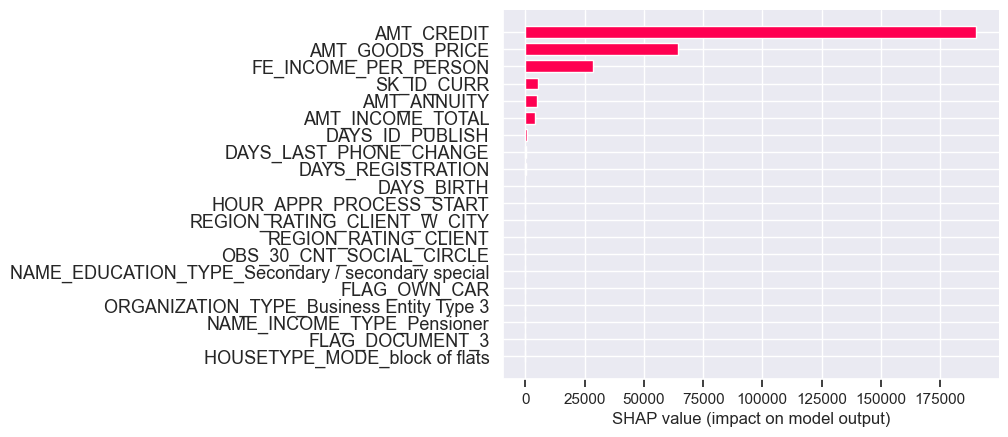

In [226]:
shap.bar_plot(
    explainer.shap_values(X_test.sample(1))[0],
    feature_names=X_test.columns,
    max_display=20,
)

In [228]:
# shap.plots.beeswarm(explainer.shap_values(X_test))

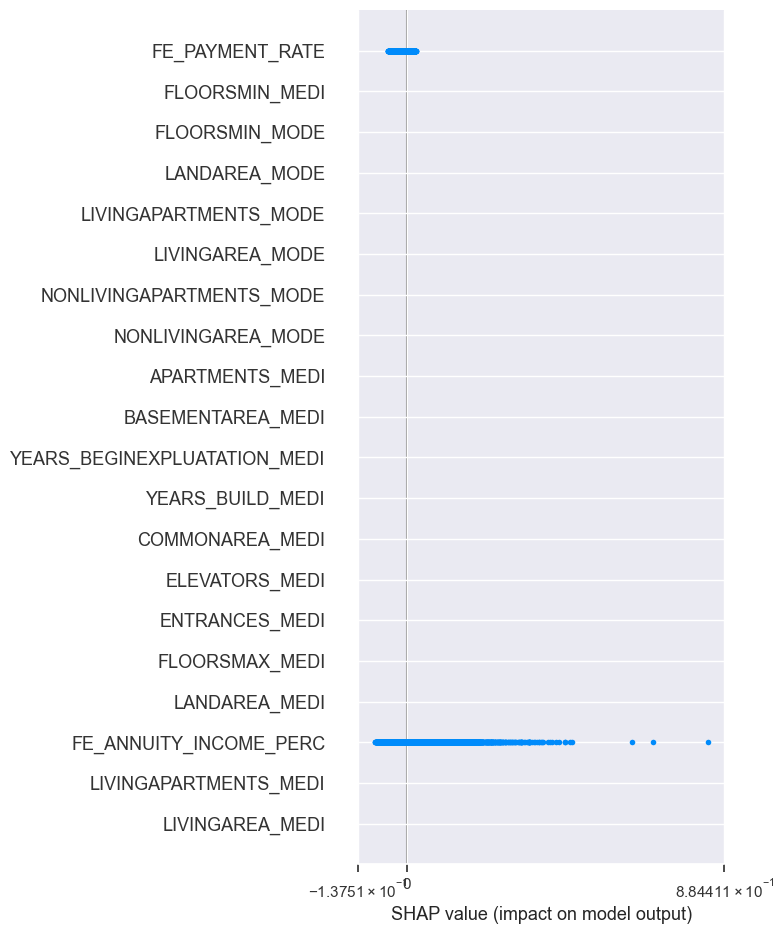

In [227]:
shap.summary_plot(
    explainer.shap_values(X_test).astype(float),
    feature_names=X_test.columns,
    use_log_scale=True,
)

# Data Drift
Pour simuler évolution des commportements utilisateurs dans le temps, on fait l'hypothèse que `app_train` représente les données d'entrainement et `app_test` les données de test.  
On applique le même nettoyage à train et test

In [ ]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

data_drift_report = Report(
    metrics=[
        DataDriftPreset(),
    ]
)

data_drift_report.run(
    reference_data=app_train.sample(frac=0.05).drop("TARGET", axis=1),
    current_data=app_test.sample(frac=0.05),
    # column_mapping=None,
)

data_drift_report.save_html("../reports/data_drift_report.html")